<a href="https://colab.research.google.com/github/tomorn112/ZC-DINO-ER/blob/part4/YoFastDuck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Mar 19 13:25:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

##**Bounding box, crop large area , save , tracking ID 1-2-3 by YOLOv8s**

In [ ]:
import os
import cv2
import numpy as np
from collections import defaultdict
from ultralytics import YOLO

# Load YOLO model
model = YOLO("yolov8s.pt")

# Get class names from the model
CLASS_NAMES = model.names

# Define target classes for detection
#TARGET_CLASSES = ["apple", "orange", "cup", "mouse", "vase", "bowl"]    #*** must be selected for some cases**************************************
#TARGET_CLASSES = ["apple", "orange", "vase"]   # *** General use these words *****************************
#TARGET_CLASSES = ["vase", "orange", "bowl'"]   # *** General use these words *****************************
#TARGET_CLASSES = ["vase", "apple", "bowl'"]
#TARGET_CLASSES = ["apple", "orange", "cup", "mouse", "vase"]
TARGET_CLASSES = ["toilet","orange", "apple", "mouse", "vase"]
#TARGET_CLASSES = [ "mouse", "apple"]


# Create output directory for cropped images
crop_dir = "/content/crop"
os.makedirs(crop_dir, exist_ok=True)

# Tracking data structures
grouped_tracks = {}
track_history = defaultdict(list)
seen_objects = {}
saved_images = {}
next_egg_id = 1
MAX_EGG_IDS = 100
DISTANCE_THRESHOLD = 75  # 75  Max distance for object tracking

def get_center(box):
    """Calculate the center of a bounding box."""
    x1, y1, x2, y2 = box
    return ((x1 + x2) // 2, (y1 + y2) // 2)

def calculate_iou(boxA, boxB):
    """Compute IoU (Intersection over Union) to measure bounding box overlap."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def crop_and_save(frame, x1, y1, x2, y2, filename):
    """Crop using valid box coordinates and save."""
    h, w, _ = frame.shape
    x1, y1, x2, y2 = np.clip([x1, y1, x2, y2], 0, [w - 1, h - 1, w - 1, h - 1])
    if x2 > x1 and y2 > y1:
        crop_img = frame[y1:y2, x1:x2]
        cv2.imwrite(filename, crop_img)
        print(f"✅ Cropped and saved: {filename}")

def track_video(video_path, output_path="output_tracked_video.mp4"):
    global next_egg_id

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return None

    # Video writer setup
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_index = 0
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        frame_index += 1
        results = model.track(frame, persist=True, imgsz=640)   # Default is 640, try 320 or 416 640

        if results and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            track_ids = results[0].boxes.id.int().cpu().tolist() if results[0].boxes.id is not None else []
            class_ids = results[0].boxes.cls.int().cpu().tolist()

            # Count occurrences of each target class in this frame
            detected_target_classes = set()
            class_count = defaultdict(int)
            for i in range(len(class_ids)):
                class_name = CLASS_NAMES[class_ids[i]]
                if class_name in TARGET_CLASSES:
                    detected_target_classes.add(class_name)
                    class_count[class_name] += 1

            # **Skip the frame if more than one unique target class appears**
            if len(detected_target_classes) > 1: ####1
                print(f"🚫 Skipping frame {frame_index}: Multiple target classes detected ({detected_target_classes})")
                continue  # Skip processing this frame

            for i, track_id in enumerate(track_ids):
                class_name = CLASS_NAMES[class_ids[i]]

                # Skip processing if the class appears more than 2 times in this frame
                if class_count[class_name] > 2:  #####2
                    print(f"🚫 Skipping {class_name} - More than 2 detected in frame {frame_index}")
                    continue

                if class_name not in TARGET_CLASSES:
                    continue

                x1, y1, x2, y2 = map(int, boxes[i])
                if x2 <= x1 or y2 <= y1:
                    continue

                center = get_center((x1, y1, x2, y2))
                frame_area = frame.shape[0] * frame.shape[1]
                bbox_area = (x2 - x1) * (y2 - y1)
                area_ratio = bbox_area / frame_area

                assigned_egg_id = None

                # Check if object is already assigned an ID
                if track_id in seen_objects:
                    assigned_egg_id = seen_objects[track_id]
                else:
                    for egg_id, tracked_ids in grouped_tracks.items():
                        for existing_id in tracked_ids:
                            if existing_id in track_history and len(track_history[existing_id]) >= 3:
                                prev_center = np.mean(track_history[existing_id][-3:], axis=0)
                                distance = np.linalg.norm(np.array(center) - np.array(prev_center))

                                # Use IoU to confirm object consistency
                                if distance < DISTANCE_THRESHOLD and calculate_iou((x1, y1, x2, y2), boxes[i]) > 0.5:
                                    assigned_egg_id = egg_id
                                    break
                        if assigned_egg_id:
                            break

                # Assign new ID if necessary
                if assigned_egg_id is None:
                    assigned_egg_id = next_egg_id
                    grouped_tracks[assigned_egg_id] = []
                    next_egg_id += 1

                # Update tracking data
                grouped_tracks[assigned_egg_id].append(track_id)
                seen_objects[track_id] = assigned_egg_id
                track_history[track_id].append(center)
                track_history[track_id] = track_history[track_id][-5:]

                # Save first detected crop if not already saved
                if assigned_egg_id not in saved_images and area_ratio > 0.6:
                    crop_filename = f"{crop_dir}/Egg_ID_{assigned_egg_id}_large_crop.jpg"
                    crop_and_save(frame, x1, y1, x2, y2, crop_filename)
                    saved_images[assigned_egg_id] = True

                # Draw on frame
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"Egg_ID {assigned_egg_id}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Write frame to output video
        out.write(frame)

    cap.release()
    out.release()
    return output_path

# Define input video path
video_path = "/content/drive/MyDrive/IEEE_Access/Videoegg/duck/mixduck3.mp4"

# Run tracking function
output_file = track_video(video_path)
if output_file:
    print(f"🎯 Tracking complete. Output saved at: {output_file}")
    print(f"📂 Cropped images saved in: {crop_dir}")



0: 384x640 (no detections), 69.4ms
Speed: 2.6ms preprocess, 69.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 2.1ms preprocess, 10.8ms i

#This section measured YOLO detecting time of 1-Egg (detection ID1 - saved ID1)

In [ ]:
import os
import cv2
import time
import numpy as np
from collections import defaultdict
from ultralytics import YOLO

# Load YOLO model
model = YOLO("yolov8s.pt")

# Get class names from the model
CLASS_NAMES = model.names

# Define target classes for detection
TARGET_CLASSES = ["toilet","orange", "apple", "mouse"]

# Create output directory for cropped images
crop_dir = "/content/crop2"
os.makedirs(crop_dir, exist_ok=True)

# Tracking data structures
grouped_tracks = {}
track_history = defaultdict(list)
seen_objects = {}
saved_images = {}
next_egg_id = 1
DISTANCE_THRESHOLD = 75

# Processing time tracking variables
start_time = None
inference_time_total = 0
stop_processing = False


def get_center(box):
    """Calculate the center of a bounding box."""
    x1, y1, x2, y2 = box
    return ((x1 + x2) // 2, (y1 + y2) // 2)


def crop_and_save(frame, x1, y1, x2, y2, filename):
    """Crop using valid box coordinates and save."""
    h, w, _ = frame.shape
    x1, y1, x2, y2 = np.clip([x1, y1, x2, y2], 0, [w - 1, h - 1, w - 1, h - 1])
    if x2 > x1 and y2 > y1:
        crop_img = frame[y1:y2, x1:x2]
        cv2.imwrite(filename, crop_img)
        print(f"✅ Cropped and saved: {filename}")


def track_video(video_path, output_path="output_tracked_video.mp4"):
    global next_egg_id, start_time, inference_time_total, stop_processing

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return None

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_index = 0

    while cap.isOpened():
        if stop_processing:
            print("\n⛔ Processing stopped because Egg_ID_1 was saved.")
            break

        success, frame = cap.read()
        if not success:
            break

        frame_index += 1
        start_inference_time = time.time()
        results = model.track(frame, persist=True, imgsz=384)  # 320 384 416 640
        end_inference_time = time.time()

        inference_time_total += (end_inference_time - start_inference_time)

        if results and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            track_ids = results[0].boxes.id.int().cpu().tolist() if results[0].boxes.id is not None else []
            class_ids = results[0].boxes.cls.int().cpu().tolist()

            detected_target_classes = set()
            class_count = defaultdict(int)
            for i in range(len(class_ids)):
                class_name = CLASS_NAMES[class_ids[i]]
                if class_name in TARGET_CLASSES:
                    detected_target_classes.add(class_name)
                    class_count[class_name] += 1

            if len(detected_target_classes) > 1:
                print(f"🚫 Skipping frame {frame_index}: Multiple target classes detected ({detected_target_classes})")
                continue

            for i, track_id in enumerate(track_ids):
                class_name = CLASS_NAMES[class_ids[i]]

                if class_count[class_name] > 2:
                    print(f"🚫 Skipping {class_name} - More than 2 detected in frame {frame_index}")
                    continue

                if class_name not in TARGET_CLASSES:
                    continue

                x1, y1, x2, y2 = map(int, boxes[i])
                if x2 <= x1 or y2 <= y1:
                    continue

                center = get_center((x1, y1, x2, y2))
                frame_area = frame.shape[0] * frame.shape[1]
                bbox_area = (x2 - x1) * (y2 - y1)
                area_ratio = bbox_area / frame_area

                assigned_egg_id = seen_objects.get(track_id, next_egg_id)
                seen_objects[track_id] = assigned_egg_id
                if assigned_egg_id == 1 and start_time is None:
                    start_time = time.time()
                    print("⏳ Timer started when Egg_ID_1 was first detected")

                if assigned_egg_id == 1 and assigned_egg_id not in saved_images and area_ratio > 0.6:
                    crop_filename = f"{crop_dir}/Egg_ID_{assigned_egg_id}_large_crop.jpg"
                    crop_and_save(frame, x1, y1, x2, y2, crop_filename)
                    saved_images[assigned_egg_id] = True
                    print("⏳ Timer started after Egg_ID_1 was saved. Stopping processing.")
                    end_time = time.time()
                    processtime1 = end_time - start_time if start_time else 0
                    print(f"⏳ Total processing time between Egg_ID_1 (detected) and Egg_ID_1 (saved): {processtime1:.6f} seconds")
                    print(f"⚡ Total inference time in this period: {inference_time_total:.6f} seconds")
                    stop_processing = True
                    break

        out.write(frame)

    cap.release()
    out.release()
    return output_path


#video_path = "/content/drive/MyDrive/IEEE_Access/Videoegg/hen/normalhen1.mp4"
output_file = track_video(video_path)
if output_file:
    print(f"🎯 Tracking complete. Output saved at: {output_file}")
    print(f"📂 Cropped images saved in: {crop_dir}")



0: 224x384 (no detections), 69.1ms
Speed: 1.1ms preprocess, 69.1ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 384)

0: 224x384 (no detections), 8.0ms
Speed: 1.1ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 384)

0: 224x384 (no detections), 10.2ms
Speed: 1.0ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 384)

0: 224x384 (no detections), 7.9ms
Speed: 1.2ms preprocess, 7.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 384)

0: 224x384 (no detections), 8.1ms
Speed: 1.1ms preprocess, 8.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 384)

0: 224x384 (no detections), 7.9ms
Speed: 1.1ms preprocess, 7.9ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 384)

0: 224x384 (no detections), 7.8ms
Speed: 1.1ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 384)

0: 224x384 (no detections), 8.2ms
Speed: 1.1ms preprocess, 8.2ms inference, 0.

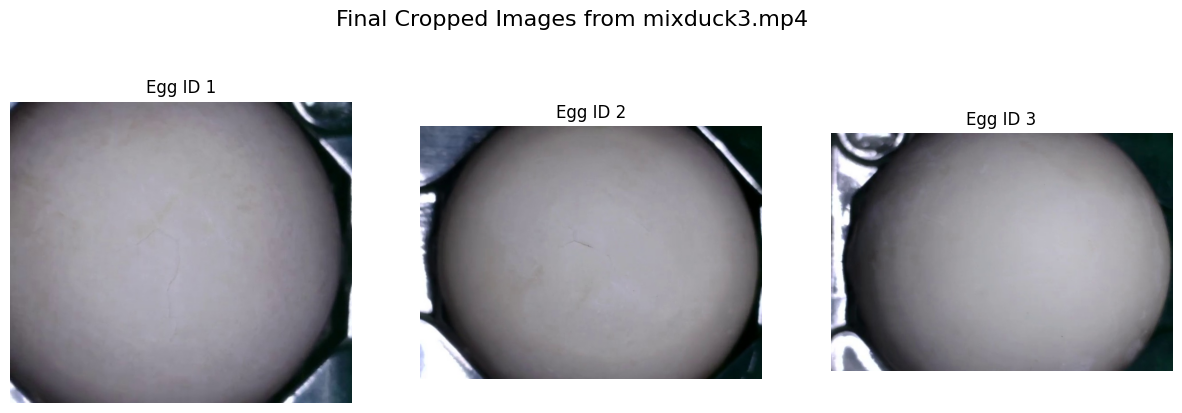

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import re

# Extract video name automatically
video_source = os.path.basename(video_path)  # Extracts "mixhen1.mp4"

# Directory containing cropped images
crop_dir = "/content/crop"

# Expected IDs
expected_ids = {1, 2, 3}

# Get all files in crop directory
existing_files = os.listdir(crop_dir)

# Extract current IDs from filenames
current_ids = set()
file_mapping = {}  # Maps current ID to file path

for filename in existing_files:
    match = re.search(r"Egg_ID_(\d+)_large_crop.jpg", filename)
    if match:
        egg_id = int(match.group(1))
        file_mapping[egg_id] = filename
        current_ids.add(egg_id)

# Identify missing IDs
missing_ids = list(expected_ids - current_ids)

# Identify incorrect IDs (IDs greater than 3)
incorrect_ids = [egg_id for egg_id in current_ids if egg_id > 3]

# Rename incorrect files to correct missing IDs
for incorrect_id, new_id in zip(sorted(incorrect_ids), sorted(missing_ids)):
    old_filename = file_mapping[incorrect_id]
    new_filename = f"Egg_ID_{new_id}_large_crop.jpg"

    old_filepath = os.path.join(crop_dir, old_filename)
    new_filepath = os.path.join(crop_dir, new_filename)

    os.rename(old_filepath, new_filepath)
    print(f"🔄 Renamed {old_filename} → {new_filename}")

# Define the expected file names for plotting
image_files = [
    f"{crop_dir}/Egg_ID_1_large_crop.jpg",
    f"{crop_dir}/Egg_ID_2_large_crop.jpg",
    f"{crop_dir}/Egg_ID_3_large_crop.jpg"
]

# Load images
images = []
for img_path in image_files:
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        images.append(img)
    else:
        print(f"⚠️ Missing image: {img_path}")

# Plot images in 1x3 layout with the video source name in the title
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Final Cropped Images from {video_source}", fontsize=16)

for ax, img, title in zip(axes, images, ["Egg ID 1", "Egg ID 2", "Egg ID 3"]):
    if img is not None:
        ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.show()


##**Removed background using Fastsam**

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# Fix locale issue in Google Colab
#import os
#os.environ["LC_ALL"] = "C.UTF-8"
#os.environ["LANG"] = "C.UTF-8"


In [ ]:
%cd {HOME}

# install FastSAM
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
!pip -q install -r FastSAM/requirements.txt
# install CLIP
!pip -q install git+https://github.com/openai/CLIP.git
# install other dependencies
!pip -q install roboflow supervision jupyter_bbox_widget

/content
fatal: destination path 'FastSAM' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done


In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!ls -lh {HOME}/weights


total 939M
-rw-r--r-- 1 root root 139M Jun 20  2023 FastSAM.pt
-rw-r--r-- 1 root root 139M Jun 20  2023 FastSAM.pt.1
-rw-r--r-- 1 root root 662M Mar 21  2023 groundingdino_swint_ogc.pth


In [ ]:
FAST_SAM_CHECKPOINT_PATH = f"{HOME}/weights/FastSAM.pt"

In [ ]:
!pip install -U git+https://github.com/ultralytics/ultralytics.git
!pip install -U git+https://github.com/CASIA-IVA-Lab/FastSAM.git


  Cloning https://github.com/ultralytics/ultralytics.git to /tmp/pip-req-build-r5s1vri2
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-r5s1vri2
  Resolved https://github.com/ultralytics/ultralytics.git to commit 2c4ac5dde7ac8c1afb30da66ae392f378e326616
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/CASIA-IVA-Lab/FastSAM.git to /tmp/pip-req-build-zx5908ri
  Running command git clone --filter=blob:none --quiet https://github.com/CASIA-IVA-Lab/FastSAM.git /tmp/pip-req-build-zx5908ri
  Resolved https://github.com/CASIA-IVA-Lab/FastSAM.git to commit b4ed20c2fed75eadc5aa7d8b09fedd137b873b52
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git (to revision a1d071733d7111c9c014f024669f959182114e33) to /tmp/pip-install-mvzrmk5v/clip_97473c717d424157be9849177aab0213
  Running

In [ ]:
%cd {HOME}/FastSAM

import os
import cv2
import torch
import roboflow
import base64
import clip
import supervision as sv
import numpy as np
from ultralytics import YOLO
from roboflow import Roboflow
#from ultralytics import FastSAM
from fastsam import FastSAM, FastSAMPrompt

/content/FastSAM


In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE = {DEVICE}")
fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

DEVICE = cuda:0


In [ ]:
import os
import time
import cv2
import torch
import numpy as np
import psutil
#from ultralytics import FastSAM  # Correct import

# Initialize FastSAM Model
#fast_sam = FastSAM("FastSAM-x.pt")  # Ensure correct model path
fast_sam = FastSAM("FastSAM-x.pt")  # Ensure correct model path
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
fast_sam.to(DEVICE)

print(f"Using FastSAM on: {DEVICE}")

# Define Input and Output Directories
crop_dir = "/content/crop"  # Directory containing Egg_ID_1, 2, 3 images
output_dir_fastsam = "/content/output_eggs_fastsam"

# Ensure output directories exist
os.makedirs(output_dir_fastsam, exist_ok=True)

# Expected file names
expected_files = [
    f"{crop_dir}/Egg_ID_1_large_crop.jpg",
    f"{crop_dir}/Egg_ID_2_large_crop.jpg",
    f"{crop_dir}/Egg_ID_3_large_crop.jpg"
]

def remove_background(image, mask):
    """Removes background, keeping only masked object."""
    mask = (mask * 255).astype(np.uint8)  # Convert boolean mask to uint8 (0 or 255)

    # Resize mask to match image size
    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Create black background
    black_background = np.zeros_like(image)

    # Apply mask: Keep only the object, rest becomes black
    result = np.where(mask_resized[:, :, None] == 255, image, black_background)

    return result  # Returns image with black background

def process_image(image_path, output_dir):
    """Processes a single image by removing background using FastSAM."""
    if not os.path.exists(image_path):
        print(f"⚠️ Skipping {image_path}: File not found.")
        return

    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error loading {image_path}. Skipping.")
        return

    print(f"🚀 Processing: {image_path}")


    # --- Start Performance Measurement ---
    start_time = time.time()
    process = psutil.Process(os.getpid())  # Monitor CPU & RAM usage

    # Run FastSAM
    results = fast_sam(source=image_path, device=DEVICE, retina_masks=True, imgsz=512, conf=0.4, iou=0.9)

    # Check if results is a list and extract the first result
    if isinstance(results, list) and len(results) > 0:
        result = results[0]  # Extract first result
    else:
        print(f"❌ No segmentation output for {image_path}, skipping.")
        return

    # Extract segmentation masks
    if hasattr(result, 'masks') and result.masks is not None:
        masks = result.masks.data.cpu().numpy()  # Convert to NumPy array
        if masks.shape[0] == 0:
            print(f"❌ No segmentation mask found for {image_path}, skipping.")
            return
        first_mask = masks[0] > 0.5  # Convert to boolean mask
    else:
        print(f"❌ No valid masks in the output for {image_path}, skipping.")
        return

    background_removed_img = remove_background(img, first_mask)

    # Save final processed image
    output_filename = os.path.join(output_dir, os.path.basename(image_path))
    cv2.imwrite(output_filename, background_removed_img)
    print(f"✅ Background removed and saved: {output_filename}")

    # --- End Performance Measurement ---
    end_time = time.time()
    print(f"⏱️ Processing time: {end_time - start_time:.3f} seconds\n")


# Process Only Egg_ID_1, Egg_ID_2, and Egg_ID_3
for image_path in expected_files:
    process_image(image_path, output_dir_fastsam)

print("🎯 All images processed successfully!")


Using FastSAM on: cuda:0
🚀 Processing: /content/crop/Egg_ID_1_large_crop.jpg



image 1/1 /content/crop/Egg_ID_1_large_crop.jpg: 480x512 4 objects, 92.1ms
Speed: 2.3ms preprocess, 92.1ms inference, 90.6ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /content/crop/Egg_ID_2_large_crop.jpg: 384x512 2 objects, 88.0ms
Speed: 1.6ms preprocess, 88.0ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 512)



✅ Background removed and saved: /content/output_eggs_fastsam/Egg_ID_1_large_crop.jpg
⏱️ Processing time: 5.428 seconds

🚀 Processing: /content/crop/Egg_ID_2_large_crop.jpg
✅ Background removed and saved: /content/output_eggs_fastsam/Egg_ID_2_large_crop.jpg
⏱️ Processing time: 0.183 seconds

🚀 Processing: /content/crop/Egg_ID_3_large_crop.jpg


image 1/1 /content/crop/Egg_ID_3_large_crop.jpg: 384x512 3 objects, 47.3ms
Speed: 1.5ms preprocess, 47.3ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 512)


✅ Background removed and saved: /content/output_eggs_fastsam/Egg_ID_3_large_crop.jpg
⏱️ Processing time: 0.135 seconds

🎯 All images processed successfully!


#Measured processtime2 for background removing

In [ ]:
import os
import time
import cv2
import torch
import numpy as np
import psutil

# Initialize FastSAM Model
fast_sam = FastSAM("FastSAM-x.pt")  # Ensure correct model path
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
fast_sam.to(DEVICE)

print(f"Using FastSAM on: {DEVICE}")

# Define Input and Output Directories
crop_dir = "/content/crop"  # Directory containing Egg_ID_1, 2, 3 images
output_dir_fastsam = "/content/output_eggs_fastsam2"

# Ensure output directories exist
os.makedirs(output_dir_fastsam, exist_ok=True)

# Expected file names
expected_files = [
    f"{crop_dir}/Egg_ID_1_large_crop.jpg",
    f"{crop_dir}/Egg_ID_2_large_crop.jpg",
    f"{crop_dir}/Egg_ID_3_large_crop.jpg"
]

def remove_background(image, mask):
    """Removes background, keeping only masked object."""
    mask = (mask * 255).astype(np.uint8)  # Convert boolean mask to uint8 (0 or 255)
    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))
    black_background = np.zeros_like(image)
    result = np.where(mask_resized[:, :, None] == 255, image, black_background)
    return result

def process_image(image_path, output_dir):
    """Processes a single image by removing background using FastSAM."""
    if not os.path.exists(image_path):
        print(f"⚠️ Skipping {image_path}: File not found.")
        return None

    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error loading {image_path}. Skipping.")
        return None

    print(f"🚀 Processing: {image_path}")

    # --- Start Performance Measurement ---
    start_time = time.time()
    process = psutil.Process(os.getpid())  # Monitor CPU & RAM usage

    # Run FastSAM
    results = fast_sam(source=image_path, device=DEVICE, retina_masks=True, imgsz=512, conf=0.4, iou=0.9)

    # Check if results is a list and extract the first result
    if isinstance(results, list) and len(results) > 0:
        result = results[0]
    else:
        print(f"❌ No segmentation output for {image_path}, skipping.")
        return None

    if hasattr(result, 'masks') and result.masks is not None:
        masks = result.masks.data.cpu().numpy()
        if masks.shape[0] == 0:
            print(f"❌ No segmentation mask found for {image_path}, skipping.")
            return None
        first_mask = masks[0] > 0.5
    else:
        print(f"❌ No valid masks in the output for {image_path}, skipping.")
        return None

    background_removed_img = remove_background(img, first_mask)
    output_filename = os.path.join(output_dir, os.path.basename(image_path))
    cv2.imwrite(output_filename, background_removed_img)
    print(f"✅ Background removed and saved: {output_filename}")

    # --- End Performance Measurement ---
    end_time = time.time()
    processtime = end_time - start_time
    print(f"⏱️ Processing time: {processtime:.3f} seconds\n")
    return processtime

# Process Only Egg_ID_1, Egg_ID_2, and Egg_ID_3
processtime2 = None
for image_path in expected_files:
    temp_time = process_image(image_path, output_dir_fastsam)
    if temp_time is not None:
        processtime2 = temp_time  # Store only the last processed image time

print("🎯 All images processed successfully!")
if processtime2 is not None:
    print(f"⏱️ Processing time 2 (last image): {processtime2:.3f} seconds\n")


Using FastSAM on: cuda:0
🚀 Processing: /content/crop/Egg_ID_1_large_crop.jpg



image 1/1 /content/crop/Egg_ID_1_large_crop.jpg: 480x512 4 objects, 69.7ms
Speed: 2.0ms preprocess, 69.7ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /content/crop/Egg_ID_2_large_crop.jpg: 384x512 2 objects, 37.6ms
Speed: 1.5ms preprocess, 37.6ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 512)



✅ Background removed and saved: /content/output_eggs_fastsam2/Egg_ID_1_large_crop.jpg
⏱️ Processing time: 0.742 seconds

🚀 Processing: /content/crop/Egg_ID_2_large_crop.jpg
✅ Background removed and saved: /content/output_eggs_fastsam2/Egg_ID_2_large_crop.jpg
⏱️ Processing time: 0.106 seconds

🚀 Processing: /content/crop/Egg_ID_3_large_crop.jpg


image 1/1 /content/crop/Egg_ID_3_large_crop.jpg: 384x512 3 objects, 37.6ms
Speed: 1.6ms preprocess, 37.6ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 512)


✅ Background removed and saved: /content/output_eggs_fastsam2/Egg_ID_3_large_crop.jpg
⏱️ Processing time: 0.109 seconds

🎯 All images processed successfully!
⏱️ Processing time 2 (last image): 0.109 seconds



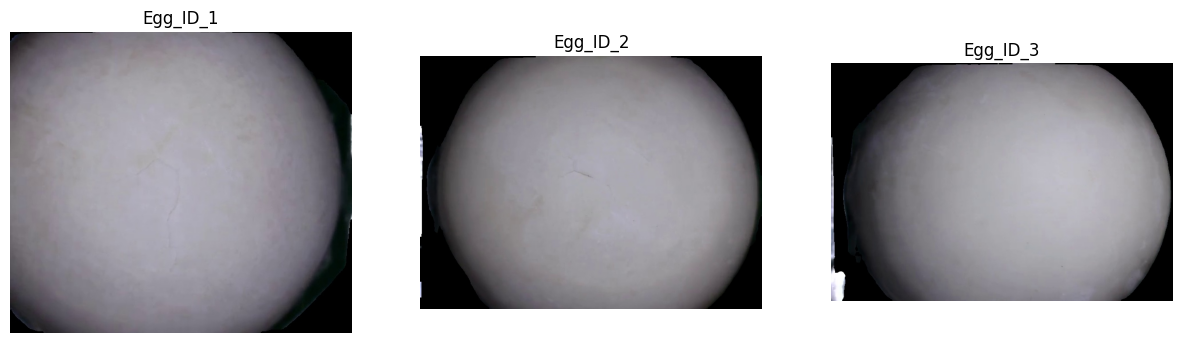

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Define image paths
output_dir = "/content/output_eggs_fastsam"
image_files = [
    f"{output_dir}/Egg_ID_1_large_crop.jpg",
    f"{output_dir}/Egg_ID_2_large_crop.jpg",
    f"{output_dir}/Egg_ID_3_large_crop.jpg"
]

# Load images
images = [cv2.imread(img) for img in image_files if os.path.exists(img)]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images if img is not None]  # Convert BGR to RGB

# Display images in a 1x3 grid
plt.figure(figsize=(15, 5))  # Adjust figure size

for i, img in enumerate(images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Egg_ID_{i+1}")

plt.show()


##**Use Grounding DINO to detect crack region**

In [ ]:
# Fix locale issue in Google Colab
#import os
#os.environ["LC_ALL"] = "C.UTF-8"
#os.environ["LANG"] = "C.UTF-8"


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git



fatal: destination path 'GroundingDINO' already exists and is not an empty directory.


In [ ]:
cd GroundingDINO/

/content/GroundingDINO


In [ ]:
!pip install torch==2.1.0 torchvision==0.16.0 --index-url https://download.pytorch.org/whl/cu121



Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
!python -c "import torch; print(torch.__version__)"


2.1.0+cu121


In [ ]:
!rm -rf build/ dist/ groundingdino.egg-info/
!pip install -e .


Obtaining file:///content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 7.6 MB/s eta 0:00:00
  Running setup.py develop for groundingdino


In [ ]:
# Create the weights directory
!mkdir -p weights

# Navigate to the weights directory and download the file
!cd weights && wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

In [ ]:
import numpy as np
print(np.__version__)


1.26.4


In [ ]:
!pip install numpy==1.26.4 ## then restart session


#Using area checking to crop crack region

final text_encoder_type: bert-base-uncased
🚀 Processing: Egg_ID_3_large_crop.jpg
🚀 Processing: Egg_ID_2_large_crop.jpg
📂 Saved cropped crack region: /content/cropped_crack_regions/cropped_Egg_ID_2_large_crop.jpg, Area: 748 pixels
🚀 Processing: Egg_ID_1_large_crop.jpg
📂 Saved cropped crack region: /content/cropped_crack_regions/cropped_Egg_ID_1_large_crop.jpg, Area: 22270 pixels


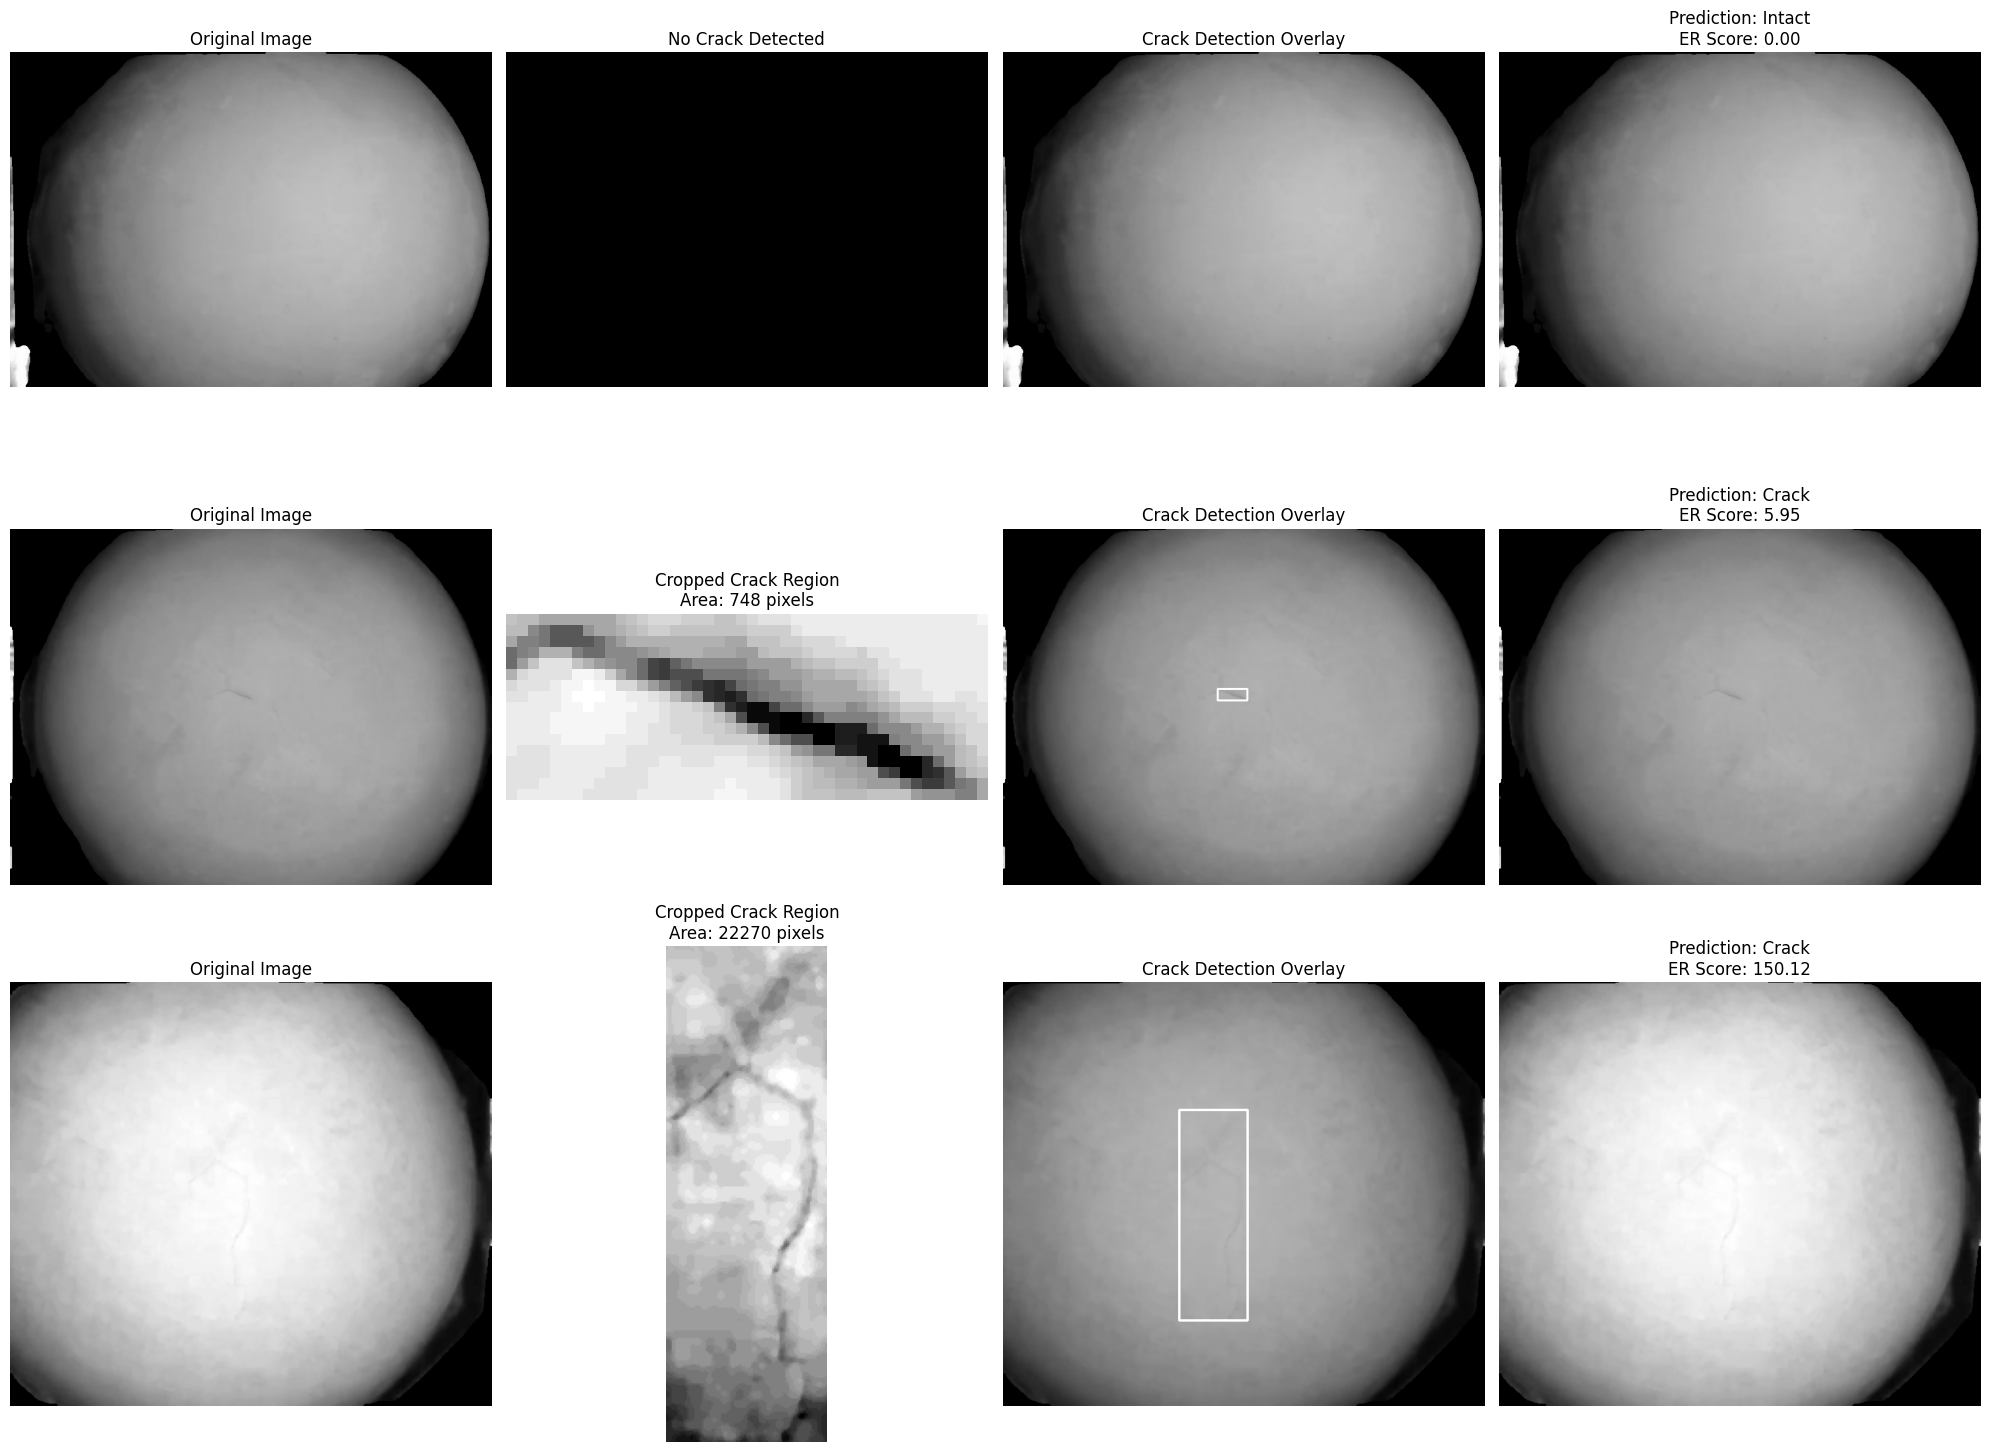

In [ ]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from groundingdino.util.inference import load_model, load_image, predict

# Load GroundingDINO Model
model = load_model("groundingdino/config/GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth")

# Define Directories
INPUT_DIR = "/content/output_eggs_fastsam"  # Background removed images
OUTPUT_DIR = "/content/processed_results"
CROPPED_CRACK_DIR = "/content/cropped_crack_regions"

# Ensure Output Directories Exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CROPPED_CRACK_DIR, exist_ok=True)

# Detection Parameters
TEXT_PROMPT = "crack"
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
UNDERT_THRESHOLD = 0.95  # Bounding box filtering threshold

def compute_fft_magnitude(image):
    """Computes the FFT magnitude spectrum of an image."""
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return magnitude_spectrum

def compute_er_score(image):
    """Computes the Outer-to-Inner Ring Energy Ratio (ER) using FFT magnitude spectrum."""
    magnitude_spectrum = compute_fft_magnitude(image)
    rows, cols = magnitude_spectrum.shape
    crow, ccol = rows // 2, cols // 2

    # Compute distance map
    y, x = np.indices((rows, cols))
    distance_map = np.sqrt((y - crow) ** 2 + (x - ccol) ** 2).astype(int)

    # Compute energy in concentric rings
    max_distance = int(np.max(distance_map))
    ring_energies = np.zeros(max_distance + 1)
    for r in range(max_distance + 1):
        ring_energies[r] = np.sum(magnitude_spectrum[distance_map == r])

    # Compute inner and outer ring energies
    inner_energy = np.sum(ring_energies[:5])  # Energy in the first 5 rings
    outer_energy = np.sum(ring_energies[5:])  # Energy outside the first 5 rings

    # Compute Outer-to-Inner Energy Ratio
    er_score = outer_energy / (inner_energy + 1e-6)  # Avoid division by zero

    return er_score

def preprocess_image(image):
    """Apply image processing to remove pigment dots while preserving cracks."""
    hsv = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(v_channel, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.medianBlur(cleaned, 3)
    return cleaned

def detect_cracks(image_path):
    """Runs GroundingDINO to detect cracks in the given image and extracts bounding boxes."""
    image_source, image = load_image(image_path)
    image_source = cv2.cvtColor(image_source, cv2.COLOR_BGR2GRAY)
    image_source = preprocess_image(image_source)

    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )

    detected = False
    cropped_region = None
    area = 0
    er_score = 0
    overlay = image_source.copy()

    if boxes is not None and len(boxes) > 0:
        valid_boxes = []
        h, w = image_source.shape[:2]
        for box in boxes:
            x_center, y_center, width, height = box.tolist()
            bbox_width = width * w
            bbox_height = height * h
            if bbox_width > 5 and bbox_height > 5 and bbox_width / w < UNDERT_THRESHOLD and bbox_height / h < UNDERT_THRESHOLD and bbox_width < 0.8 * w and bbox_height < 0.8 * h:
                valid_boxes.append([x_center, y_center, bbox_width / w, bbox_height / h])

        if len(valid_boxes) > 0:
            detected = True
            for box in valid_boxes:
                x_center, y_center, width, height = box
                x_min = int((x_center - width / 2) * w)
                y_min = int((y_center - height / 2) * h)
                x_max = int((x_center + width / 2) * w)
                y_max = int((y_center + height / 2) * h)
                x_min, y_min = max(0, x_min), max(0, y_min)
                x_max, y_max = min(w, x_max), min(h, y_max)
                cropped_region = image_source[y_min:y_max, x_min:x_max]
                area = (x_max - x_min) * (y_max - y_min)

                cv2.rectangle(overlay, (x_min, y_min), (x_max, y_max), (255, 255, 255), 2)

                if cropped_region.size > 0:
                    cropped_path = os.path.join(CROPPED_CRACK_DIR, f"cropped_{os.path.basename(image_path)}")
                    cv2.imwrite(cropped_path, cropped_region)
                    print(f"📂 Saved cropped crack region: {cropped_path}, Area: {area} pixels")

                    # Compute ER Score
                    er_score = compute_er_score(cropped_region)
                    break

    # Adjust prediction based on ER Score and Area
    prediction = "Crack" if detected and er_score >= 5 and area >= 200 else "Intact"
    return prediction, image_source, cropped_region, overlay, area, er_score

def process_images():
    """Processes all images in the input directory and displays results for all images in 1 row, 4 columns per test."""
    image_files = [f for f in os.listdir(INPUT_DIR) if f.endswith((".jpg", ".png"))]
    if not image_files:
        print("No images found.")
        return

    plt.figure(figsize=(20, 5 * len(image_files)))

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(INPUT_DIR, image_file)
        print(f"🚀 Processing: {image_file}")
        prediction, original_image, cropped_region, overlay, area, er_score = detect_cracks(image_path)

        plt.subplot(len(image_files), 4, idx * 4 + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(len(image_files), 4, idx * 4 + 2)
        if cropped_region is not None:
            plt.imshow(cropped_region, cmap="gray")
            plt.title(f"Cropped Crack Region\nArea: {area} pixels")
        else:
            plt.imshow(np.zeros_like(original_image), cmap="gray")
            plt.title("No Crack Detected")
        plt.axis("off")

        plt.subplot(len(image_files), 4, idx * 4 + 3)
        plt.imshow(overlay, cmap='gray')
        plt.title("Crack Detection Overlay")
        plt.axis("off")

        plt.subplot(len(image_files), 4, idx * 4 + 4)
        plt.imshow(original_image, cmap='gray')
        plt.title(f"Prediction: {prediction}\nER Score: {er_score:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    process_images()


In [ ]:
import os
import time
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from groundingdino.util.inference import load_model, load_image, predict

# Load GroundingDINO Model
model = load_model("groundingdino/config/GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth")

# Define Directories
INPUT_DIR = "/content/output_eggs_fastsam"  # Background removed images
OUTPUT_DIR = "/content/processed_results"
CROPPED_CRACK_DIR = "/content/cropped_crack_regions"

# Ensure Output Directories Exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CROPPED_CRACK_DIR, exist_ok=True)

# Detection Parameters
TEXT_PROMPT = "crack"
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
UNDERT_THRESHOLD = 0.95  # Bounding box filtering threshold

def compute_fft_magnitude(image):
    """Computes the FFT magnitude spectrum of an image."""
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return magnitude_spectrum

def compute_er_score(image):
    """Computes the Outer-to-Inner Ring Energy Ratio (ER) using FFT magnitude spectrum."""
    magnitude_spectrum = compute_fft_magnitude(image)
    rows, cols = magnitude_spectrum.shape
    crow, ccol = rows // 2, cols // 2

    y, x = np.indices((rows, cols))
    distance_map = np.sqrt((y - crow) ** 2 + (x - ccol) ** 2).astype(int)

    max_distance = int(np.max(distance_map))
    ring_energies = np.zeros(max_distance + 1)
    for r in range(max_distance + 1):
        ring_energies[r] = np.sum(magnitude_spectrum[distance_map == r])

    inner_energy = np.sum(ring_energies[:5])
    outer_energy = np.sum(ring_energies[5:])
    er_score = outer_energy / (inner_energy + 1e-6)

    return er_score

def preprocess_image(image):
    """Apply image processing to remove pigment dots while preserving cracks."""
    hsv = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(v_channel, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.medianBlur(cleaned, 3)
    return cleaned

def detect_cracks(image_path):
    """Runs GroundingDINO to detect cracks in the given image and extracts bounding boxes."""
    start_time = time.time()

    image_source, image = load_image(image_path)
    image_source = cv2.cvtColor(image_source, cv2.COLOR_BGR2GRAY)
    image_source = preprocess_image(image_source)

    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )

    detected = False
    cropped_region = None
    area = 0
    er_score = 0
    overlay = image_source.copy()

    if boxes is not None and len(boxes) > 0:
        valid_boxes = []
        h, w = image_source.shape[:2]
        for box in boxes:
            x_center, y_center, width, height = box.tolist()
            bbox_width = width * w
            bbox_height = height * h
            if bbox_width > 5 and bbox_height > 5 and bbox_width / w < UNDERT_THRESHOLD and bbox_height / h < UNDERT_THRESHOLD and bbox_width < 0.8 * w and bbox_height < 0.8 * h:
                valid_boxes.append([x_center, y_center, bbox_width / w, bbox_height / h])

        if len(valid_boxes) > 0:
            detected = True
            for box in valid_boxes:
                x_center, y_center, width, height = box
                x_min = int((x_center - width / 2) * w)
                y_min = int((y_center - height / 2) * h)
                x_max = int((x_center + width / 2) * w)
                y_max = int((y_center + height / 2) * h)
                x_min, y_min = max(0, x_min), max(0, y_min)
                x_max, y_max = min(w, x_max), min(h, y_max)
                cropped_region = image_source[y_min:y_max, x_min:x_max]
                area = (x_max - x_min) * (y_max - y_min)

                cv2.rectangle(overlay, (x_min, y_min), (x_max, y_max), (255, 255, 255), 2)

                if cropped_region.size > 0:
                    cropped_path = os.path.join(CROPPED_CRACK_DIR, f"cropped_{os.path.basename(image_path)}")
                    cv2.imwrite(cropped_path, cropped_region)
                    print(f"📂 Saved cropped crack region: {cropped_path}, Area: {area} pixels")

                    er_score = compute_er_score(cropped_region)
                    break

    prediction = "Crack" if detected and er_score >= 20 and area >= 200 else "Intact"
    processing_time = time.time() - start_time
    print(f"⏳ Processing time for {os.path.basename(image_path)}: {processing_time:.6f} seconds")
    return prediction, image_source, cropped_region, overlay, area, er_score, processing_time

def process_images():
    """Processes all images in the input directory and keeps track of the last image processing time."""
    image_files = [f for f in os.listdir(INPUT_DIR) if f.endswith((".jpg", ".png"))]
    if not image_files:
        print("No images found.")
        return

    plt.figure(figsize=(20, 5 * len(image_files)))
    processtime3 = None  # Store last image processing time

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(INPUT_DIR, image_file)
        print(f"🚀 Processing: {image_file}")
        prediction, original_image, cropped_region, overlay, area, er_score, temp_time = detect_cracks(image_path)
        processtime3 = temp_time  # Update processtime3 for each image, storing the last one

    plt.tight_layout()
    plt.show()

    if processtime3 is not None:
        print(f"⏱️ Processing time 3 (last image): {processtime3:.3f} seconds\n")

if __name__ == "__main__":
    process_images()

final text_encoder_type: bert-base-uncased
🚀 Processing: Egg_ID_3_large_crop.jpg
⏳ Processing time for Egg_ID_3_large_crop.jpg: 0.654808 seconds
🚀 Processing: Egg_ID_2_large_crop.jpg
📂 Saved cropped crack region: /content/cropped_crack_regions/cropped_Egg_ID_2_large_crop.jpg, Area: 748 pixels
⏳ Processing time for Egg_ID_2_large_crop.jpg: 0.321959 seconds
🚀 Processing: Egg_ID_1_large_crop.jpg
📂 Saved cropped crack region: /content/cropped_crack_regions/cropped_Egg_ID_1_large_crop.jpg, Area: 22270 pixels
⏳ Processing time for Egg_ID_1_large_crop.jpg: 0.282216 seconds


<Figure size 2000x1500 with 0 Axes>

⏱️ Processing time 3 (last image): 0.282 seconds



In [ ]:
import cv2

# Manually input processing times for each step due to runtime restart session
processtime1 =   2.474340   # Example time for step 1
processtime2 =  0.109      # Example time for step 2
processtime3 = 0.282      # Example time for step 3

# Compute total processing time per egg
total_processtime_per_egg = processtime1 + processtime2 + processtime3

# Print processing times
print(f"⏱️ Processing time 1: {processtime1:.3f} seconds")
print(f"⏱️ Processing time 2: {processtime2:.3f} seconds")
print(f"⏱️ Processing time 3: {processtime3:.3f} seconds")
print(f"⚡ Total Processing Time per Egg: {total_processtime_per_egg:.3f} seconds")

# Define input video path
video_path = "/content/drive/MyDrive/IEEE_Access/Videoegg/duck/mixduck3.mp4" #12.50

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total frames

# Manually input video duration (seconds)
duration_sec = float(input("Enter the manually measured video duration in seconds: "))

# Assume 3 eggs detected in the video
egg_count = 3

# Compute real transfer time per egg
real_transfer_time_per_egg = duration_sec / egg_count if egg_count > 0 else 0

# Compute estimated transfer speed in Eggs/hour
eggs_per_sec = egg_count / duration_sec if duration_sec > 0 else 0
estimated_eggs_per_hour = eggs_per_sec * 3600  # Convert to eggs per hour

# Compute the difference between real transfer time per egg and total processing time per egg
time_difference = real_transfer_time_per_egg - total_processtime_per_egg

# Release video capture
cap.release()

# Display results
print(f"\n📌 Total Frames in Video: {total_frames}")
print(f"⏳ Manually Entered Video Duration: {duration_sec:.2f} seconds")
print(f"🐣 Estimated Transfer Speed: {estimated_eggs_per_hour:.2f} Eggs/hour")
print(f"⏱️ Real Transfer Time per Egg: {real_transfer_time_per_egg:.3f} seconds")
print(f"⚡ Difference (Real Transfer Time - Total Processing Time per Egg): {time_difference:.3f} seconds")


⏱️ Processing time 1: 2.474 seconds
⏱️ Processing time 2: 0.109 seconds
⏱️ Processing time 3: 0.282 seconds
⚡ Total Processing Time per Egg: 2.865 seconds
Enter the manually measured video duration in seconds: 12.50

📌 Total Frames in Video: 1076
⏳ Manually Entered Video Duration: 12.50 seconds
🐣 Estimated Transfer Speed: 864.00 Eggs/hour
⏱️ Real Transfer Time per Egg: 4.167 seconds
⚡ Difference (Real Transfer Time - Total Processing Time per Egg): 1.301 seconds
